In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import graphviz
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report


%run utility_functions.py # functions reused throughout

0    16258
1     1639
Name: 0, dtype: int64

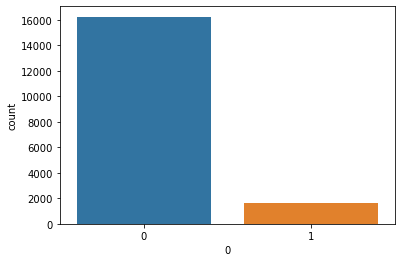

In [2]:
# Dataset source:
# http://archive.ics.uci.edu/ml/datasets/HTRU2#

# Read in data
data = pd.read_csv('../data/HTRU2/HTRU_2.csv', sep=',')

sns.countplot(data.iloc[:,-1]) # plot number of things with each value

data.iloc[:,-1].value_counts(sort=True)
# skewed toward predicting negative

In [3]:
# Create training, testing, and validation sets

X = data.drop(data.columns[-1], axis=1) # last value is the pulsar indicator

y = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2) # 80/20 default

# scale so it converges
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train = scaling.transform(x_train)
x_test = scaling.transform(x_test)

In [4]:
# default 'adam'
clf = MLPClassifier(random_state=0, early_stopping=True)

#https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
# between 1-8 hidden layers, with mean of # input and output (5)
hidden_layers = [(5), 
                 (5, 5), 
                 (5, 5, 5), 
                 (5, 5, 5, 5), 
                 (5, 5, 5, 5, 5,), 
                 (5, 5, 5, 5, 5, 5), 
                 (5, 5, 5, 5, 5, 5, 5)]

parameters = {'hidden_layer_sizes': hidden_layers,
              'alpha': [0.01, 0.001, 0.0001],
              'max_iter': [300, 400, 500],
              'n_iter_no_change': [10, 20, 30, 40],              
              'learning_rate': ['constant', 'adaptive', 'invscaling']
             }

# filter warnings

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Scorer for parameter combinations
acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, cv=5, n_jobs=4)
grid_obj = grid_obj.fit(x_train, y_train)

# Set clf to best combination of parameters
clf = grid_obj.best_estimator_
clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': True,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (5, 5, 5, 5, 5, 5),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 300,
 'momentum': 0.9,
 'n_iter_no_change': 20,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 0,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [5]:
# train model
clf.fit(x_train, y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(5, 5, 5, 5, 5, 5),
              max_iter=300, n_iter_no_change=20, random_state=0)

No Skill: ROC AUC=0.500
Model: ROC AUC=0.977


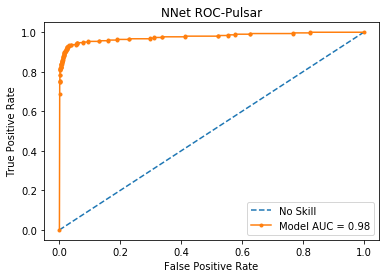

Model: f1=0.878 auc=0.932


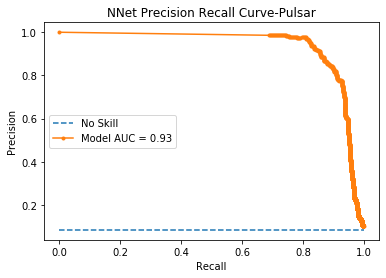

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3277
           1       0.90      0.85      0.88       303

    accuracy                           0.98      3580
   macro avg       0.94      0.92      0.93      3580
weighted avg       0.98      0.98      0.98      3580

Confusion Matrix
[[3249   28]
 [  44  259]]


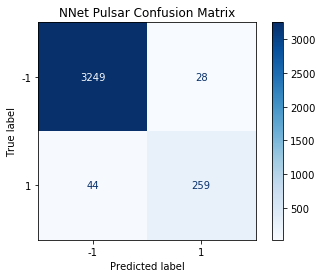

<module 'matplotlib.pyplot' from 'c:\\users\\spcbe\\miniconda3\\envs\\ml_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

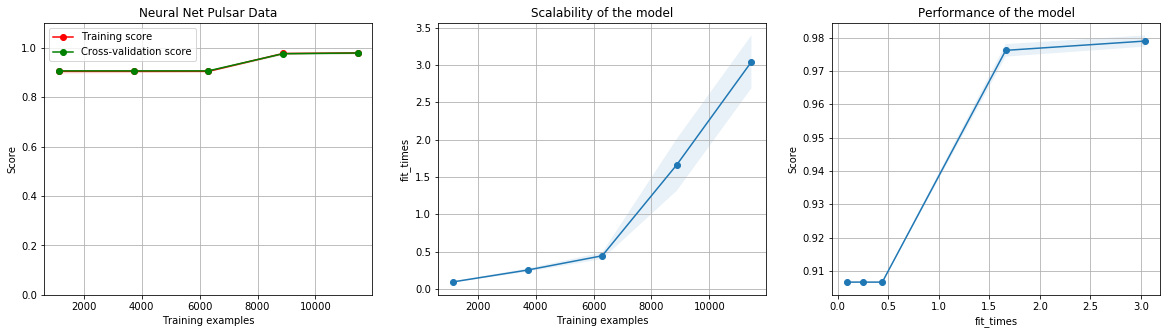

In [6]:
# test
y_predict = clf.predict(x_test)

# ROC
plot_roc(clf, x_test, y_test, y_predict, 'NNet ROC-Pulsar')
# Recall_precision_curve
plot_precision_recall_curve(clf, x_test, y_test, y_predict, 'NNet Precision Recall Curve-Pulsar')


# how did we do? Comparing y_test and predicted values
print('Classification Report')
print(classification_report(y_test, y_predict,zero_division=1))
print('Confusion Matrix')
# how to interpret: https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28
print(confusion_matrix(y_test, y_predict))

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm = plot_confusion_matrix(clf, x_test, y_test,
                                 display_labels=['-1', '1'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
cm.ax_.set_title('NNet Pulsar Confusion Matrix')
plt.savefig('../images/cm_NNet_Pulsar.png')
plt.show()

#print('Accuracy')
#print(accuracy_score(y_test, y_predict))

# for unbalanced data
#print('Balanced Accuracy')
#print(balanced_accuracy_score(y_test, y_predict))

# 1.1 so I can see the top of the plot
plot_learning_curve(clf, "Neural Net Pulsar Data", x_train, y_train, ylim=[0,1.1])

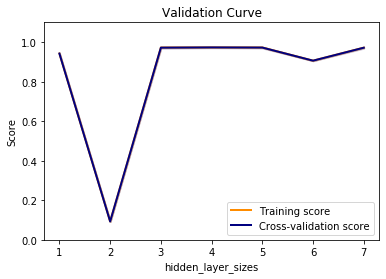

In [7]:
plot_model_complexity_analysis(clf, 'hidden_layer_sizes', [1, 2, 3, 4, 5, 6, 7], 'NNet_pulsar',
                               x_train, y_train)

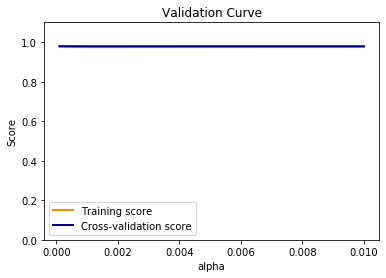

In [8]:
plot_model_complexity_analysis(clf, 'alpha', [0.01, 0.001, 0.0001], 'NNet_pulsar', x_train, y_train)

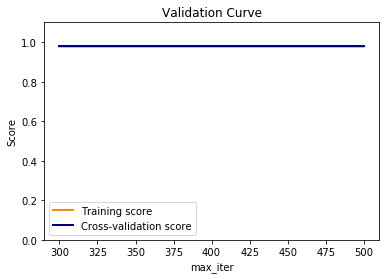

In [9]:
plot_model_complexity_analysis(clf, 'max_iter', [300, 400, 500], 'NNet_pulsar', x_train, y_train)

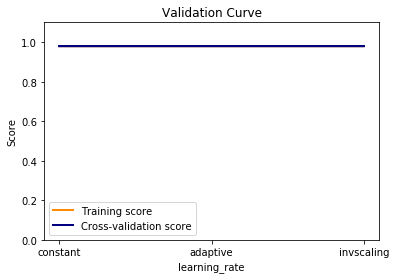

In [10]:
plot_model_complexity_analysis(clf, 'learning_rate', ['constant', 'adaptive', 'invscaling'], 'NNet_pulsar', x_train, y_train)

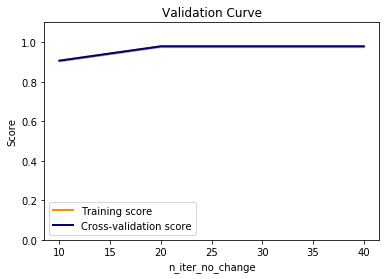

In [11]:
plot_model_complexity_analysis(clf, 'n_iter_no_change', [10, 20, 30, 40], 'NNet_pulsar', x_train, y_train)